In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#!pip install pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

import warnings
warnings.filterwarnings("ignore")
sns.set_style()

In [3]:
dados = pd.read_csv(r'D:\Blue EdTech\Bootcamp\dados\full_grouped.csv')

In [91]:
df = dados[dados['Country/Region'].isin(['Mexico', 'Argentina', 
                                        'Ecuador', 'Chile', 'Spain'])]

df['Date'] = pd.to_datetime(df.Date, format="%Y-%m-%d")

## SARIMAX (baseline)

##### Diferença entre os novos casos por dia

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: >)

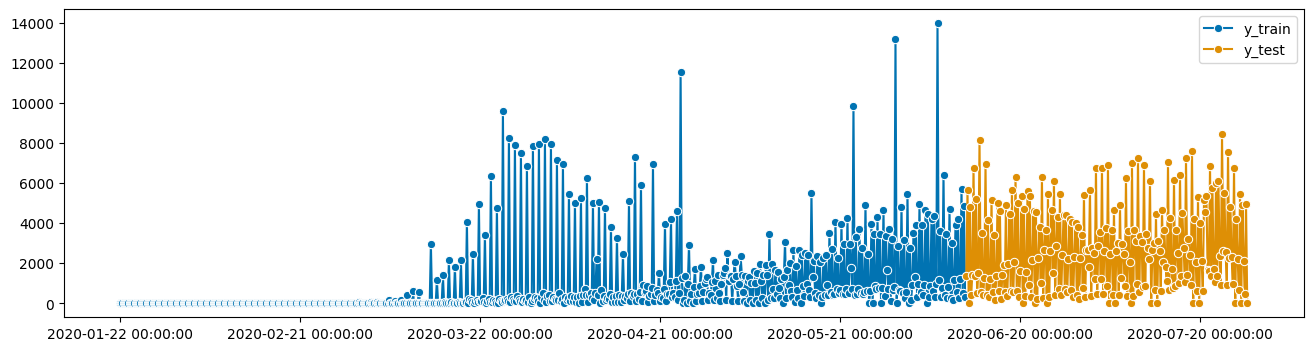

In [92]:
y = pd.Series(df['New cases'].values, df['Date'].values)
y_train, y_test = temporal_train_test_split(y)

plot_series(y_train, y_test, labels=["y_train", "y_test"])

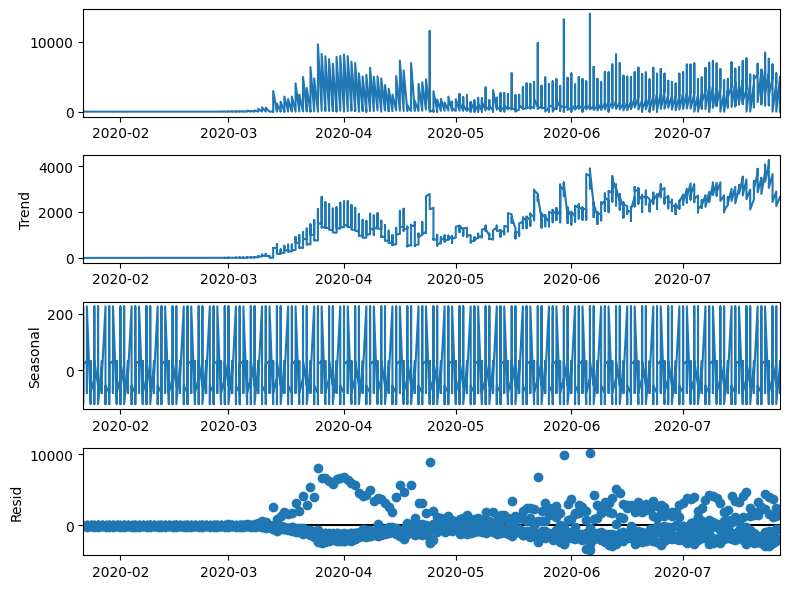

In [93]:
# decompor por semana
result = seasonal_decompose(y, model='additive', period=7)

fig = result.plot()
fig.set_size_inches((8, 6))

fig.tight_layout()
plt.show()

Foi utilizado a função seasonal_decompose da biblioteca stats models para dividir a série em três elementos: Tendência (trend), sazonalidade (seasonal) e resíduo (resid)

##### Aplicando a tecnica de SARIMAX na coluna 'New cases'

In [94]:
novos_casos = df[['Date','New cases']].copy()

# criando o modelo
auto_arima(novos_casos['New cases'],seasonal=True,m=7)

# ajustando o modelo
# colocamos os parametros start_p e start_q em 0 para
# serem os valores iniciais de treino e colocamos os 
# parametros max_p e max_q nos valores finais. 
# m=7 que será de observacoes diária
stepwise_fit = auto_arima(novos_casos['New cases'], start_p=0, start_q=0, 
    max_p=6, max_q=3, m=7,
    seasonal=True,
    trace=False,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True)

stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  940
Model:             SARIMAX(6, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -7812.491
Date:                                Thu, 15 Dec 2022   AIC                          15648.981
Time:                                        16:14:02   BIC                          15707.119
Sample:                                             0   HQIC                         15671.145
                                                - 940                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0658      0.067     -0.978      0.328      -0.198       0.066
ar.L2         -0.2108      0.036     -5.889      0.000      -0.281      -0.141
ar.L3         -0.1325      0.048     -2.785      0.005      -0.226      -0.039
ar.L4         -0.1369      0.054     -2.536      0.011      -0.243      -0.031
ar.L5          0.5595      0.039     14.221      0.000       0.482       0.637
ar.L6         -0.0750      0.061     -1.221      0.222      -0.195       0.045
ma.L1         -0.9501      0.022    -44.086      0.000      -0.992      -0.908
ar.S.L7        0.6284      0.032     19.671      0.000       0.566       0.691
ar.S.L14      -0.9396      0.026    -36.649      0.000      -0.990      -0.889
ma.S.L7       -0.5477      0.054    -10.208      0.000      -0.653      -0.443
ma.S.L14       0.7981      0.049     16.450      0.000       0.703       0.893
sigma2       1.12e+06   2.35e+04     47.665      0.000    1.07e+06    1.17e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):             54439.23
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               8.51   Skew:                             2.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        39.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

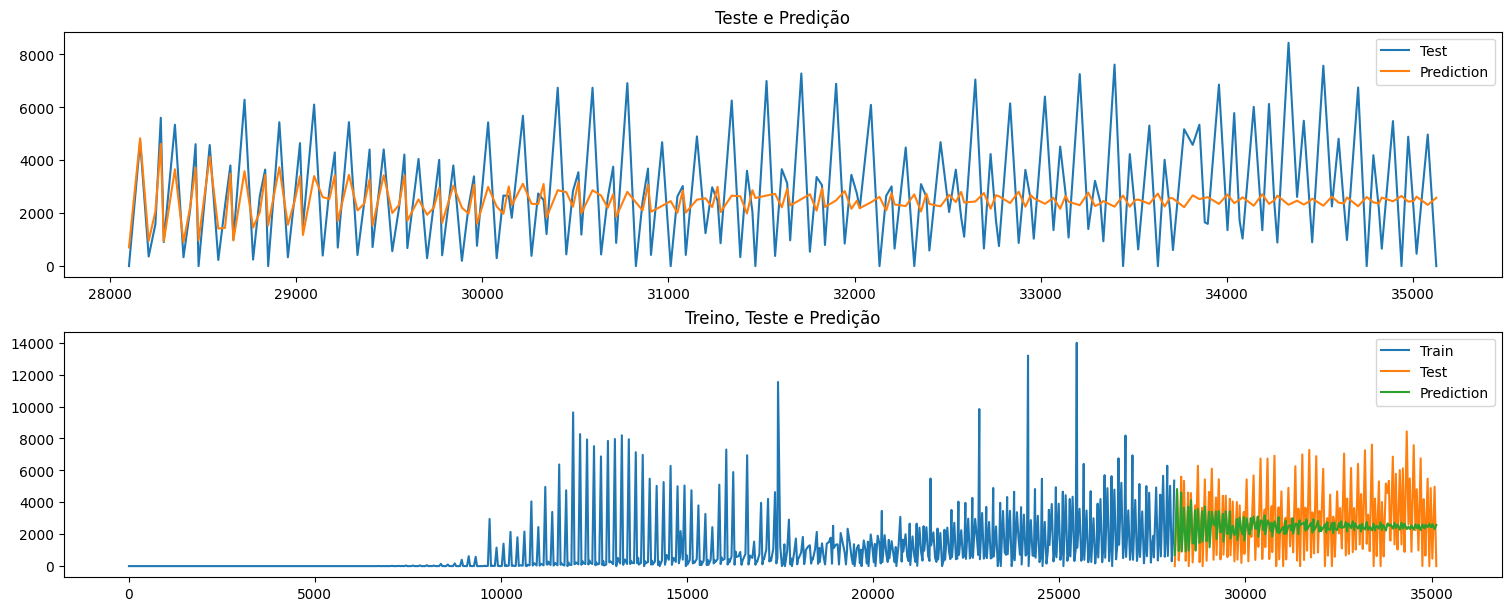

In [96]:
cut = int(novos_casos.shape[0] * 0.80)
train = novos_casos.iloc[:cut]
test = novos_casos.iloc[cut:]

# modelo
model = SARIMAX(train['New cases'],order=(6,1,1),seasonal_order=(2,0,[1,2],7))
model_fit = model.fit()

start = train.shape[0]
end   = novos_casos.shape[0] - 1

pred = model_fit.predict(start=start, end=end, dynamic=False, typ='levels')
pred.index = test.index

# Graficos de predição
fig, axs = plt.subplots(2, 1, figsize=(15, 6), constrained_layout=True)

ax = axs[0]
ax.set_title(r'Teste e Predição')
ax.plot(test['New cases'], label='Test') # color='orange'
ax.plot(pred, label='Prediction') # color='green'
ax.legend(loc='best')

ax = axs[1]
ax.set_title(r'Treino, Teste e Predição')
ax.plot(train['New cases'], label='Train')
ax.plot(test['New cases'], label='Test')
ax.plot(pred, label='Prediction')
ax.legend(loc='best')

plt.show()

In [97]:
print(f"R²   ---  {r2_score(test['New cases'], pred):.2f}")
print(f"MAE  ---  {mean_absolute_error(test['New cases'], pred):.2f}")
print(f"RMSE ---  {mean_squared_error(test['New cases'], pred, squared=False):.2f}")
print(f"MAPE ---  {mean_absolute_percentage_error(test['New cases'], pred)}")

R²   ---  0.10
MAE  ---  1598.92
RMSE ---  2034.90
MAPE ---  7.005516650594642e+17


## Estacionariedade e Dickey Fuller

### Funções

#### criar_serie
* com confirmados e obitos
* a coluna de data como index

In [15]:
def criar_serie(df, nome_pais):

    filtro = df[df['Country/Region'] == nome_pais]
    pais = filtro[['Date', 'Confirmed', 'Deaths']]
    
    pd.to_datetime(pais.Date)
    pais.set_index('Date', inplace=True)
    
    return pais

In [16]:
argentina = criar_serie(df, 'Argentina')
chile = criar_serie(df, 'Chile')
equador = criar_serie(df, 'Ecuador')
mexico = criar_serie(df, 'Mexico')
espanha = criar_serie(df, 'Spain')

In [17]:
full_serie = criar_serie(df, df['Country/Region'])

#### media_movel

In [18]:
def media_movel(serie, periodo):
    
    fig, axs = plt.subplots(2, 1, figsize=(15, 5), constrained_layout=True)

    # Valores originais
    ax = axs[0]
    mm = serie.Confirmed.resample(periodo).mean() # O periodo da media movel pode ser um numero inteiro seguido de D, W, M, Y ou apenas as iniciais
    ax.set_title(r'Valor original e média movel de Confirmados')
    ax.plot(serie.Confirmed, color='blue', label='Original')
    ax.plot(mm, color='red', label='Média movel')
    ax.legend(loc='best')

    # Media movel
    ax = axs[1]
    mm = serie.Deaths.resample(periodo).mean()
    ax.set_title(r'Valor original e média movel de Obitos')
    ax.plot(serie.Deaths, color='blue', label='Original')
    ax.plot(mm, color='red', label='Média movel')
    ax.legend(loc='best')


    return plt.show

### Analise de tendencia

O '.resample(periodo).mean()' na função media_movel irá retornar a media movel, fazendo com que seja possivel observar o grafico da serie sem os ruidos, facilitando a analise de tendencia dos dados.

Para entender melhor como funciona a media movel, suposmos que será utilizado o periodo de 15 dias para o salto da janela de observação, os primeiro 14 dias serão pulados, e apenas o dia 15 será observado, apartir desse dia, a media do dia posterior será calculada baseada na media dos 15 dias anteriores e o processo será repetido até o fim da serie.

<function matplotlib.pyplot.show(close=None, block=None)>

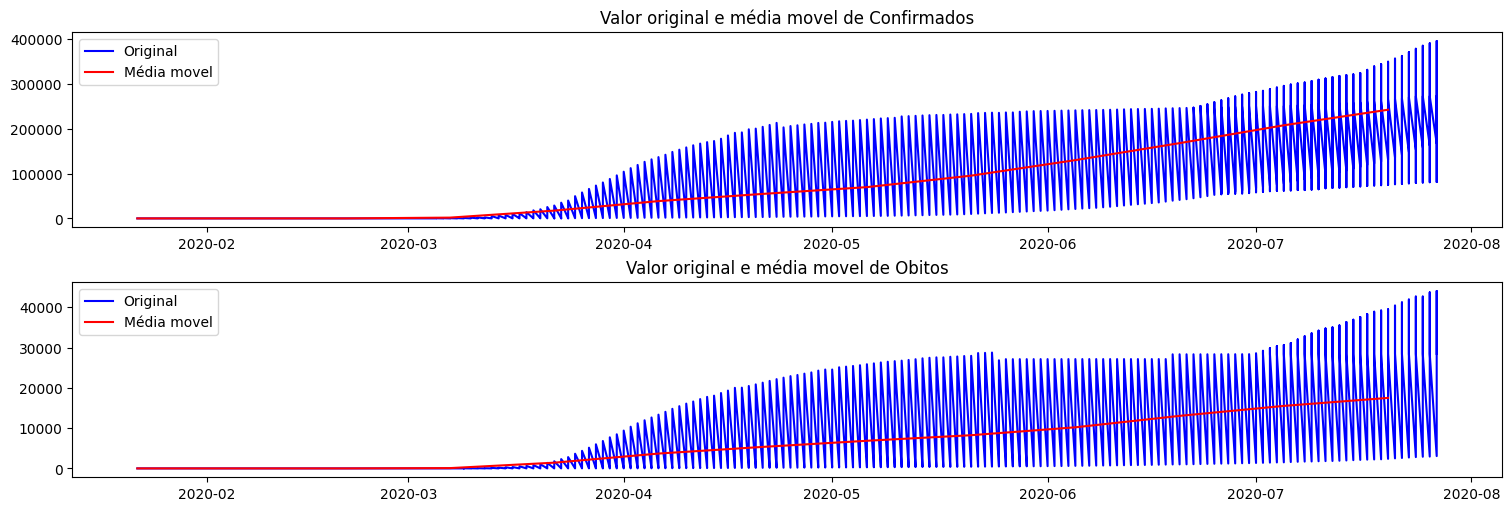

In [19]:
media_movel(full_serie, periodo='15D')

### Analise de sazionalidade

diff() ou diferença sucessiva, defini quantas diferenças será utilizado, por padrão o periodo é 1. (pesquisar sobre diferença sucessiva)

<AxesSubplot: xlabel='Date'>

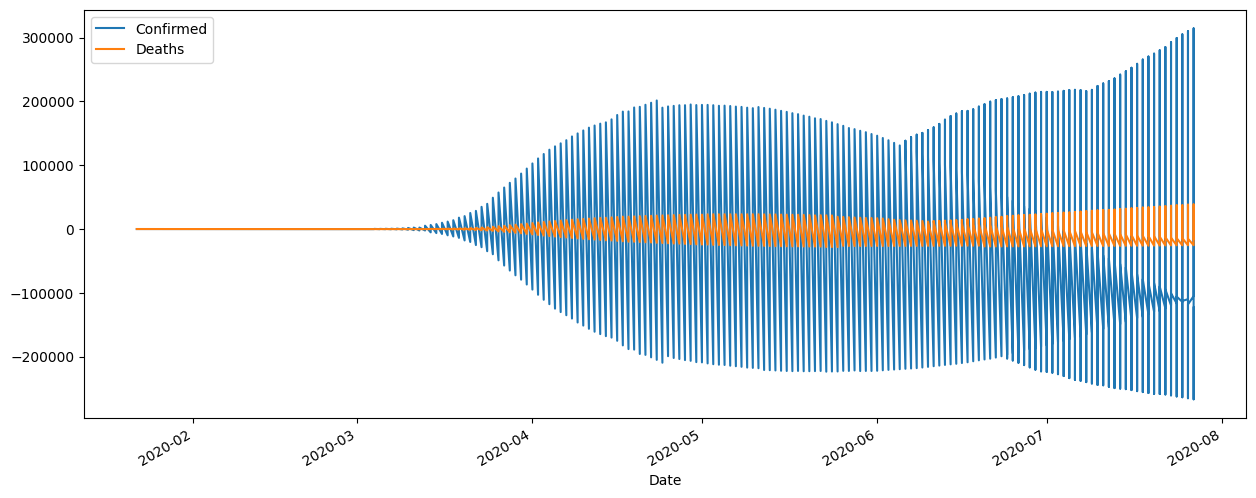

In [20]:
full_serie.diff().plot(figsize=(15,6)) 

<AxesSubplot: xlabel='Date'>

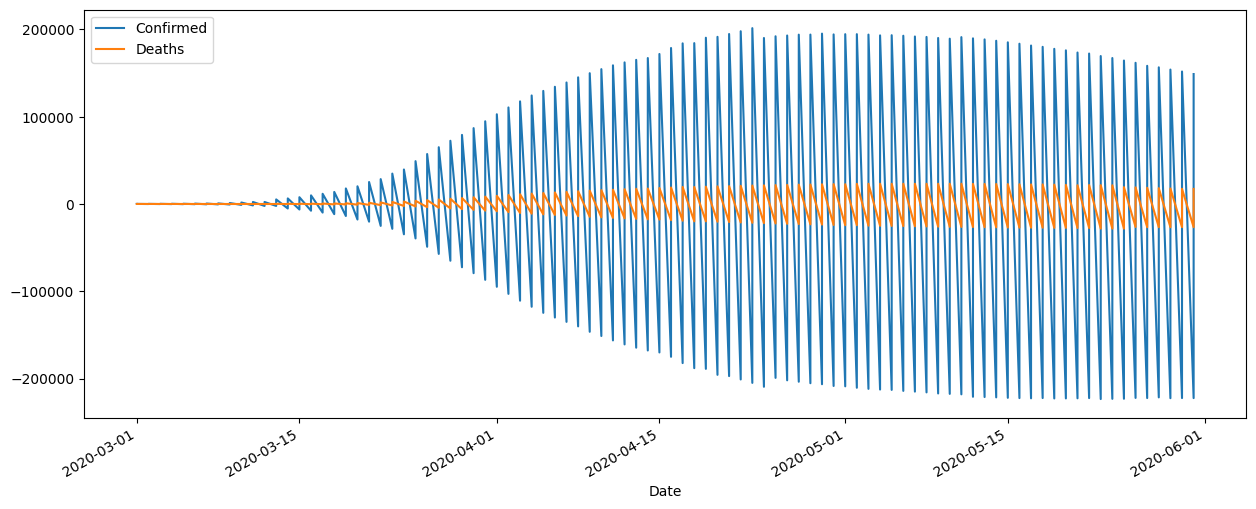

In [21]:
# criando filtros para analiser melhor o grafico
filtro = (full_serie.index.month >= 3) & (full_serie.index.month <=5)
full_serie[filtro].diff().plot(figsize=(15,6))

### Analisando ADF e Testando modelo SARIMAX

In [22]:
from statsmodels.tsa.stattools import adfuller

ADF Statistic: 1.0198679084570061
p-value: 0.9944712170177812
                                       SARIMAX Results                                        
Dep. Variable:                              Confirmed   No. Observations:                  188
Model:             SARIMAX(6, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -1643.025
Date:                                Thu, 15 Dec 2022   AIC                           3310.050
Time:                                        11:51:25   BIC                           3348.824
Sample:                                    01-22-2020   HQIC                          3325.761
                                         - 07-27-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.597

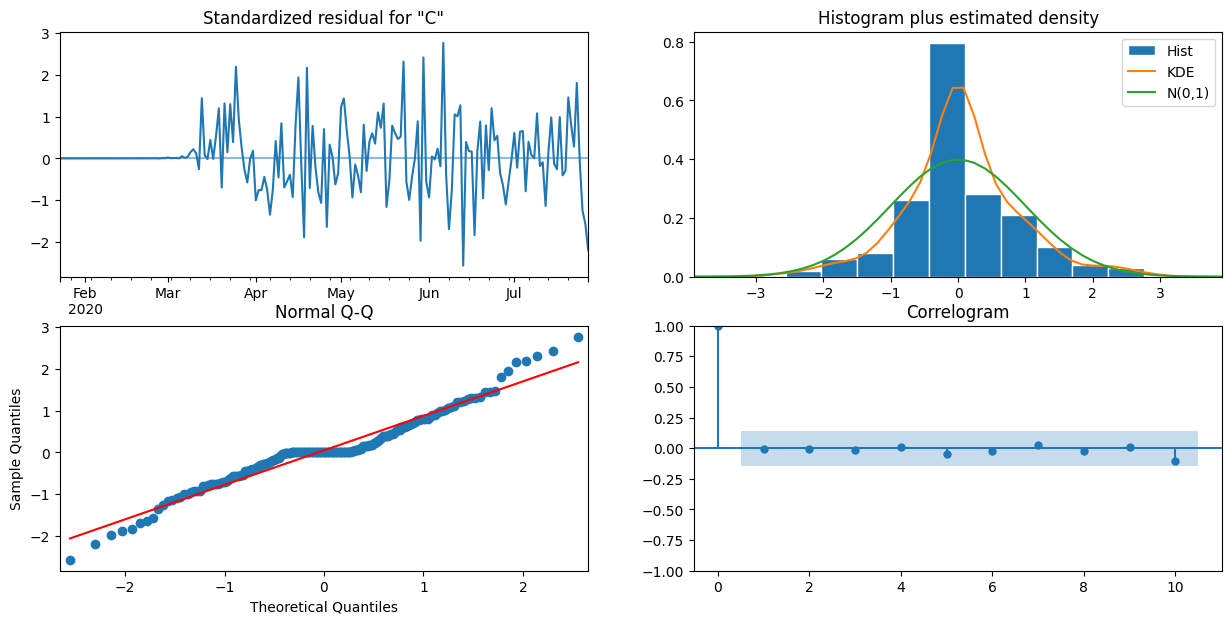

In [23]:
X = full_serie.groupby('Date').Confirmed.sum().copy()

# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(X)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')


# SARIMA Model
best_model = SARIMAX(X,order=(6,1,1),seasonal_order=(2,0,[1,2],7)).fit(dis=1)
print(best_model.summary()) # .tables[1]
best_model.plot_diagnostics(figsize=(15,7))
plt.show()

## SARIMAX (ajustado)

### Funções

#### modelo_SARIMAX

In [58]:
def modelo_SARIMAX(serie, coluna, ordem, ordem_sazonal):
    
    X = serie.groupby('Date')[coluna].sum().copy()
    
    cut = int(X.shape[0] * 0.80)
    train = X.iloc[:cut]
    test = X.iloc[cut:]
    
    start = train.shape[0]
    end   = X.shape[0] - 1

    # modelo
    model = SARIMAX(train, 
                    order=ordem,
                    seasonal_order=ordem_sazonal).fit(dis=1)
    
    pred = model.predict(start=start,
                         end=end,
                         dynamic=False,
                         typ='levels')
    pred.index = test.index
    
    #Metricas
    print(f"R²   ---  {r2_score(test, pred):.2f}")
    print(f"MAE  ---  {mean_absolute_error(test, pred):.2f}")
    print(f"RMSE ---  {mean_squared_error(test, pred, squared=False):.2f}")
    print(f"MAPE ---  {mean_absolute_percentage_error(test, pred)}")


    # Graficos de predição
    fig, axs = plt.subplots(2, 1, figsize=(15, 6), constrained_layout=True)

    ax = axs[0]
    ax.set_title(r'Teste e Predição')
    ax.plot(test, label='Test') # color='orange'
    ax.plot(pred, label='Prediction') # color='green'
    ax.legend(loc='best')

    ax = axs[1]
    ax.set_title(r'Treino, Teste e Predição')
    ax.plot(train, label='Train')
    ax.plot(test, label='Test')
    ax.plot(pred, label='Prediction')
    ax.legend(loc='best')

    plt.show()

#### arima_automatico

In [77]:
def arima_automatico(serie, coluna):
    
    serie_coluna = serie.groupby('Date')[coluna].sum().copy()
    
    # criando o modelo
    auto_arima(serie_coluna,seasonal=True,m=7)

    # ajustando o modelo
    # colocamos os parametros start_p e start_q em 0 para
    # serem os valores iniciais de treino e colocamos os 
    # parametros max_p e max_q nos valores finais. 
    # m=7 que será de observacoes diária
    stepwise_fit = auto_arima(serie_coluna, start_p=0, start_q=0, 
        max_p=6, max_q=3, m=7,
        seasonal=True,
        trace=False, # True caso queira observar os valores de cada fit
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True)

    return stepwise_fit.summary()

### Analisando predição de confirmados

R²   ---  0.92
MAE  ---  30688.83
RMSE ---  42371.80
MAPE ---  0.027373405289024457


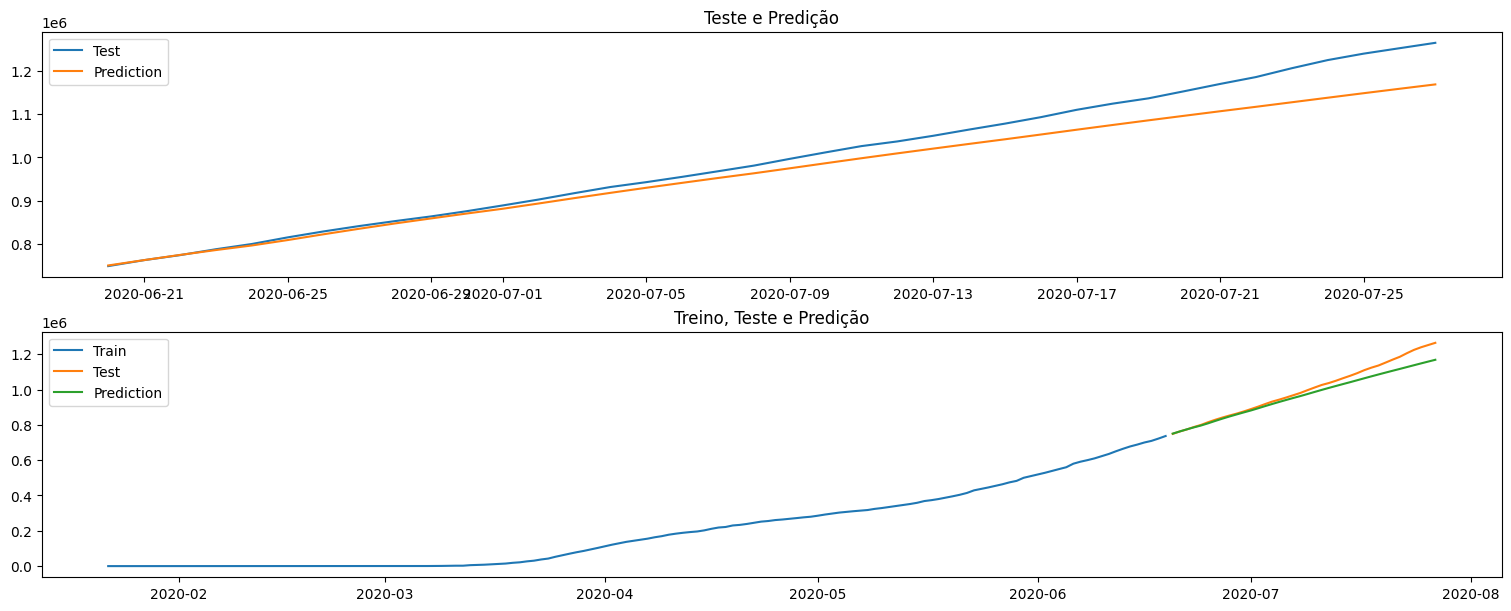

In [86]:
modelo_SARIMAX(serie = full_serie,
               coluna = ['Confirmed'],
               ordem = (6,1,1),
               ordem_sazonal= (2,0,[1,2],7)) # sem auto_arima

In [87]:
arima_automatico(serie = full_serie,
                 coluna = ['Confirmed'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  188
Model:             SARIMAX(2, 2, 1)x(1, 0, [], 7)   Log Likelihood               -1633.769
Date:                            Thu, 15 Dec 2022   AIC                           3277.539
Time:                                    15:37:41   BIC                           3293.668
Sample:                                01-22-2020   HQIC                          3284.075
                                     - 07-27-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0998      0.113      0.883      0.377      -0.122       0.321
ar.L2          0.2051      0.109      1.886      0.059      -0.008       0.418
ma.L1         -0.8125      0.094     -8.657      0.000      -0.996      -0.629
ar.S.L7        0.5744      0.038     15.166      0.000       0.500       0.649
sigma2      2.468e+06   2.03e+05     12.184      0.000    2.07e+06    2.87e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                16.92
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               4.26   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

R²   ---  0.98
MAE  ---  16763.64
RMSE ---  23619.03
MAPE ---  0.014941680144294204


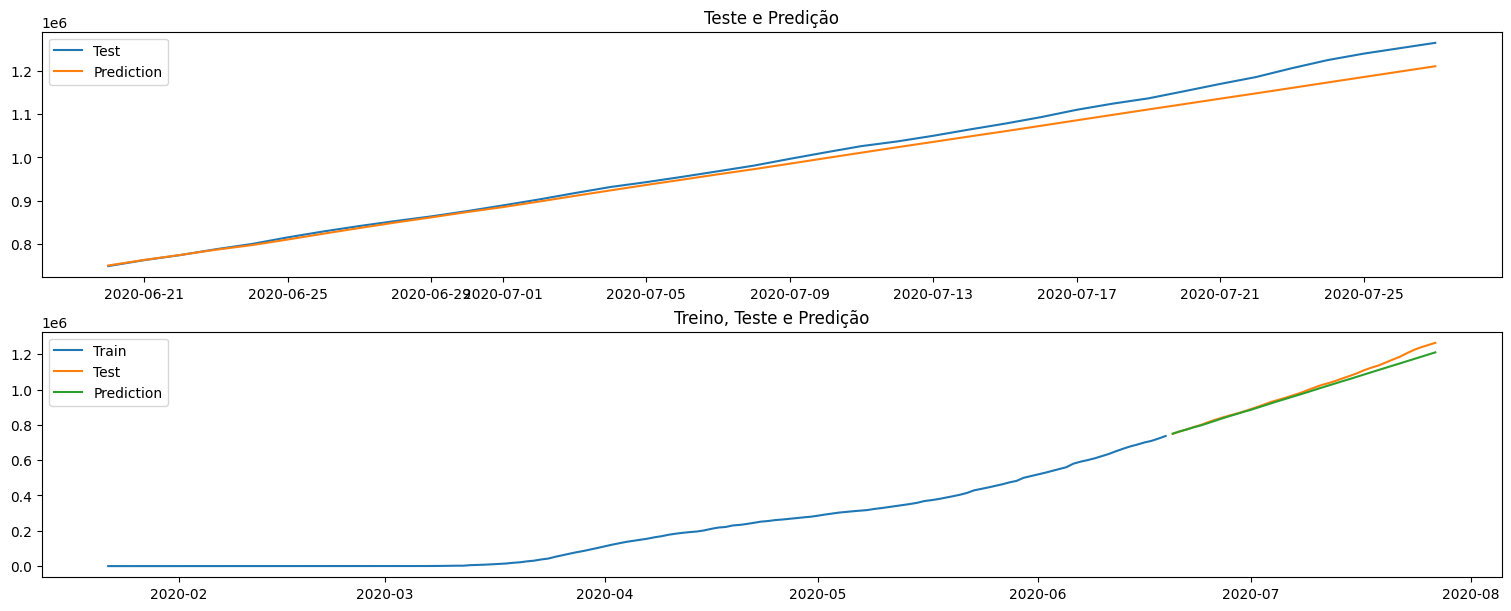

In [88]:
modelo_SARIMAX(serie = full_serie,
               coluna = ['Confirmed'], 
               ordem = (2, 2, 1),
               ordem_sazonal= (1, 0, [], 7)) # com auto_arima

É possivel notar mais uma melhora consideral nos resultados da analise das predições do numero de confirmados, saindo de um R² 0.92 para R² 0.98, além de um MAPE também menor.

### Analisando predição dos obitos

R²   ---  -0.32
MAE  ---  9199.71
RMSE ---  10619.88
MAPE ---  0.11594263067531795


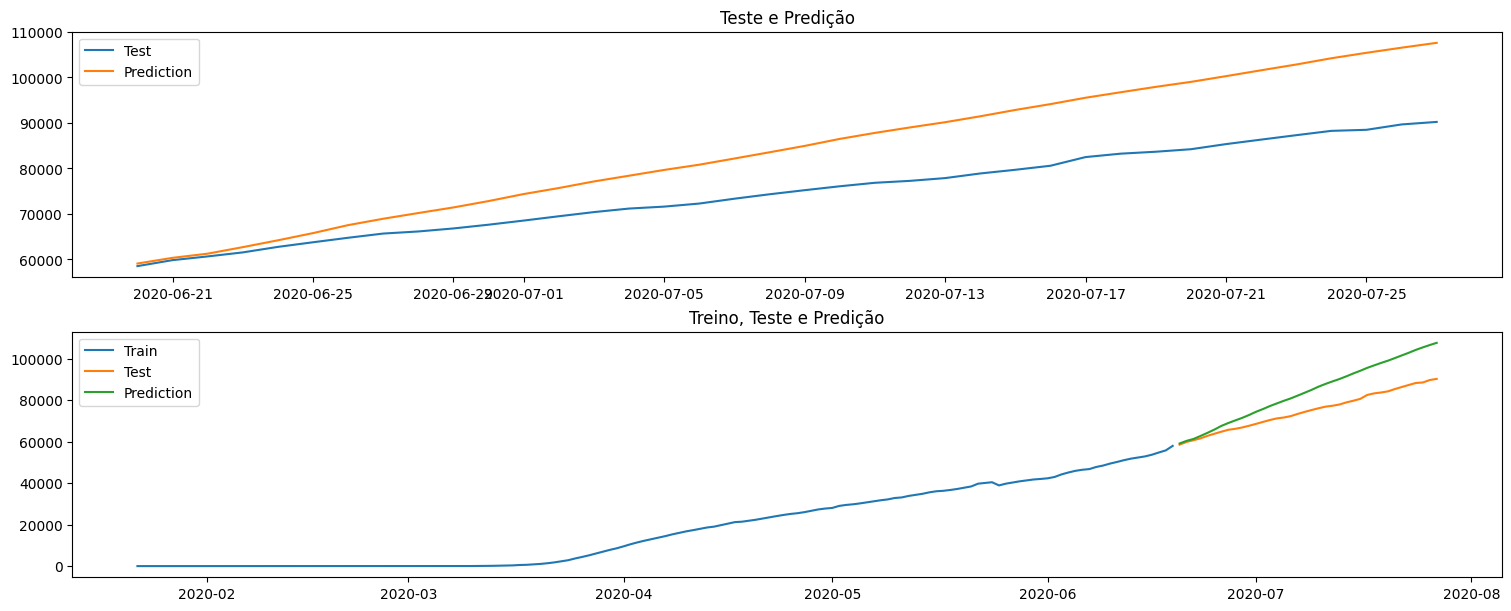

In [60]:
# baseline com os parametros 'ordem' e 'ordem_sazonal'
# iguais ao da analise de "Confirmed"
modelo_SARIMAX(serie = full_serie,
               coluna = ['Deaths'],
               ordem = (6,1,1),
               ordem_sazonal= (2,0,[1,2],7))

In [79]:
arima_automatico(serie = full_serie,
                 coluna = ['Deaths'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  188
Model:             SARIMAX(1, 2, 2)x(1, 0, [1], 7)   Log Likelihood               -1308.151
Date:                             Thu, 15 Dec 2022   AIC                           2628.302
Time:                                     15:21:48   BIC                           2647.657
Sample:                                 01-22-2020   HQIC                          2636.145
                                      - 07-27-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8022      0.232     -3.459      0.001      -1.257      -0.348
ma.L1         -0.0521      0.255     -0.204      0.838      -0.553       0.448
ma.L2         -0.5318      0.220     -2.422      0.015      -0.962      -0.101
ar.S.L7        0.9420      0.093     10.150      0.000       0.760       1.124
ma.S.L7       -0.8122      0.136     -5.992      0.000      -1.078      -0.547
sigma2      7.392e+04   3160.205     23.391      0.000    6.77e+04    8.01e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2414.01
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              12.72   Skew:                            -1.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

R²   ---  -0.91
MAE  ---  10949.68
RMSE ---  12778.26
MAPE ---  0.1375723009833041


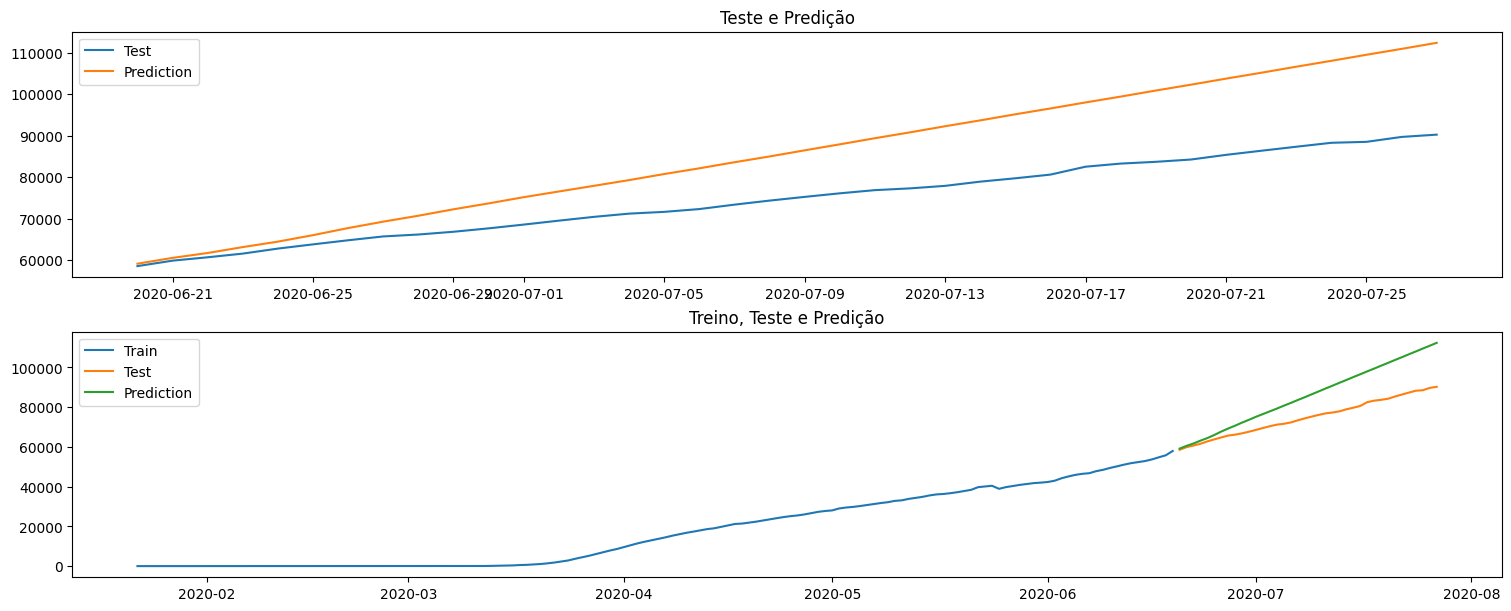

In [68]:
# os paramentros 'ordem' e 'ordem_sazonal' foram definidos 
# utilizando a função arima_automatico
modelo_SARIMAX(serie = full_serie,
               coluna = ['Deaths'],
               ordem = (1, 2, 2),
               ordem_sazonal= (1, 0, [1], 7))

O resultado negativo do R² (-0.91) indica que as variaveis estão correlacionadas negativamente, e por está muito proximo de -1,0 essa associação pode ser considerada uma associação negativamente forte.

Podemos interpretar esse resultado da seguintemente maneira: o modelo preditivo está indicando que ao passar do tempo o numero de mortes tenderá a queda.

### Sobre as metricas

Erro Médio Absoluto (MAE), que é a média dos erros absolutos (ignorando o sinal positivo ou negativo). Assim sabemos melhor quanto estamos desviando dos valores reais nas unidades originais.

Erro Percentual Absoluto Médio (MAPE). É uma métrica bastante utilizada na área de previsões de séries temporais, e se refere à média do percentual de erros cometidos nas previsões, desconsiderando a direção (acima ou abaixo do real).